In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we don't know whether or not these houses even have basements, and we have 21,597 entries anyway, we choose to drop these.

In [5]:
house_data = house_data[house_data.sqft_basement != '?']
house_data['sqft_basement'] = house_data['sqft_basement'].astype(float)
house_data['sqft_basement'].value_counts().head()

0.0      12826
600.0      217
500.0      209
700.0      208
800.0      201
Name: sqft_basement, dtype: int64

In [6]:
house_data['view'].isna().sum()

61

We have 61 NaN values for view. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

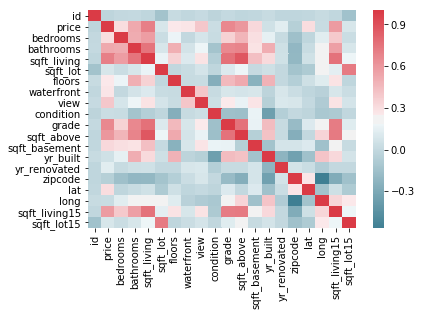

In [9]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [10]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016413,0.002267,0.005873,-0.011866,-0.132412,0.019150,-0.004114,0.012859,-0.023410,0.008765,-0.010757,-0.004480,0.022179,-0.010372,-0.010959,-0.005062,0.021254,-0.003084,-0.138114
price,-0.016413,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.272661,0.397176,0.034613,0.668099,0.605481,0.323018,0.054849,0.128517,-0.053429,0.307667,0.022512,0.586495,0.083530
bedrooms,0.002267,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,-0.001839,0.080379,0.025652,0.356418,0.478967,0.301987,0.156820,0.018979,-0.152539,-0.009939,0.131398,0.391936,0.030779
bathrooms,0.005873,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.065559,0.187249,-0.128167,0.665992,0.685959,0.281813,0.508866,0.051479,-0.204016,0.025243,0.224660,0.569396,0.089414
sqft_living,-0.011866,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.108855,0.283797,-0.061626,0.762719,0.876787,0.433369,0.319584,0.054105,-0.198987,0.053213,0.241473,0.756199,0.184920
sqft_lot,-0.132412,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.022598,0.072668,-0.009207,0.113801,0.183653,0.015612,0.052469,0.003641,-0.129626,-0.085076,0.230489,0.143815,0.719499
floors,0.019150,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.020870,0.027748,-0.264259,0.459144,0.523594,-0.245628,0.489898,0.002684,-0.058443,0.049237,0.125360,0.279379,-0.011632
waterfront,-0.004114,0.272661,-0.001839,0.065559,0.108855,0.022598,0.020870,1.000000,0.404847,0.017261,0.086431,0.073915,0.087926,-0.025964,0.083825,0.030884,-0.012267,-0.038770,0.088693,0.031551
view,0.012859,0.397176,0.080379,0.187249,0.283797,0.072668,0.027748,0.404847,1.000000,0.045464,0.250014,0.166907,0.276521,-0.054415,0.098948,0.085300,0.006174,-0.076306,0.280934,0.072797
condition,-0.023410,0.034613,0.025652,-0.128167,-0.061626,-0.009207,-0.264259,0.017261,0.045464,1.000000,-0.148886,-0.159186,0.170361,-0.361838,-0.062166,0.002616,-0.016021,-0.105805,-0.093556,-0.004386


Zipcode and longitude have a strong negative correlation with each other, and we expect latitude/longitude to be far more useful predictors than zipcode. So we choose to drop zipcode as well.

We drop sqft_above and sqft_living15 in favor of sqft_living as well, due to their high multicollinearity. 

We dropped grade because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms.

In [11]:
house_data = house_data.drop('yr_renovated', axis=1)
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
#Bathrooms and bedrooms have high correlation with sqft_living.
#However, we choose not to remove them yet. Maybe experiment with that?
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [12]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 16 columns):
id               21082 non-null int64
date             21082 non-null object
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_living      21082 non-null int64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       18749 non-null float64
view             21082 non-null float64
condition        21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
lat              21082 non-null float64
long             21082 non-null float64
sqft_lot15       21082 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.7+ MB


In [13]:
# Waterfront has null values, since the number of nulls is a little high, fill with the highest categorical which is 0
house_data = house_data.fillna(0)

In [14]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 16 columns):
id               21082 non-null int64
date             21082 non-null object
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_living      21082 non-null int64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       21082 non-null float64
view             21082 non-null float64
condition        21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
lat              21082 non-null float64
long             21082 non-null float64
sqft_lot15       21082 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.7+ MB


Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

In [15]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

In [16]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166


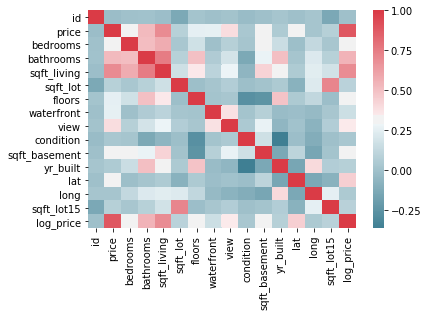

In [17]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [18]:
# we want to target our model to the majority of users, 
# but perhaps not to the people that are buying mansions/celebrities in the area
price_90th_perc = np.percentile(house_data['log_price'], 90)

house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)
house_data_90.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18973 entries, 0 to 21596
Data columns (total 17 columns):
id               18973 non-null int64
date             18973 non-null object
price            18973 non-null float64
bedrooms         18973 non-null int64
bathrooms        18973 non-null float64
sqft_living      18973 non-null int64
sqft_lot         18973 non-null int64
floors           18973 non-null float64
waterfront       18973 non-null float64
view             18973 non-null float64
condition        18973 non-null int64
sqft_basement    18973 non-null float64
yr_built         18973 non-null int64
lat              18973 non-null float64
long             18973 non-null float64
sqft_lot15       18973 non-null int64
log_price        18973 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 2.6+ MB


In [19]:
price_95th_perc = np.percentile(house_data['log_price'], 95)

house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)
house_data_95.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20039 entries, 0 to 21596
Data columns (total 17 columns):
id               20039 non-null int64
date             20039 non-null object
price            20039 non-null float64
bedrooms         20039 non-null int64
bathrooms        20039 non-null float64
sqft_living      20039 non-null int64
sqft_lot         20039 non-null int64
floors           20039 non-null float64
waterfront       20039 non-null float64
view             20039 non-null float64
condition        20039 non-null int64
sqft_basement    20039 non-null float64
yr_built         20039 non-null int64
lat              20039 non-null float64
long             20039 non-null float64
sqft_lot15       20039 non-null int64
log_price        20039 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 2.8+ MB


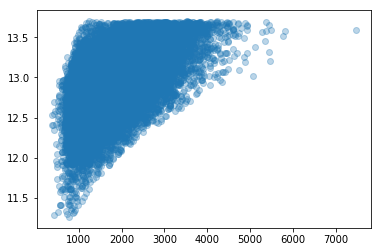

In [20]:
plt.scatter(house_data_90['sqft_living'], house_data_90['log_price'], alpha=0.3)

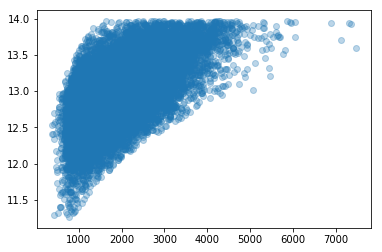

In [21]:
plt.scatter(house_data_95['sqft_living'], house_data_95['log_price'], alpha=0.3)

In [22]:
# remove strong outliers in sqft_living and bedrooms
house_data_90 = house_data_90.drop(house_data_90[house_data_90['sqft_living'] > 12000].index)
house_data_90 = house_data_90.drop(house_data_90[house_data_90['bedrooms']>30].index)

house_data_95 = house_data_95.drop(house_data_95[house_data_95['sqft_living'] > 12000].index)
house_data_95 = house_data_95.drop(house_data_95[house_data_95['bedrooms']>30].index)

house_data_90.describe(), house_data_90.info(), house_data_95.describe(), house_data_95.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18972 entries, 0 to 21596
Data columns (total 17 columns):
id               18972 non-null int64
date             18972 non-null object
price            18972 non-null float64
bedrooms         18972 non-null int64
bathrooms        18972 non-null float64
sqft_living      18972 non-null int64
sqft_lot         18972 non-null int64
floors           18972 non-null float64
waterfront       18972 non-null float64
view             18972 non-null float64
condition        18972 non-null int64
sqft_basement    18972 non-null float64
yr_built         18972 non-null int64
lat              18972 non-null float64
long             18972 non-null float64
sqft_lot15       18972 non-null int64
log_price        18972 non-null float64
dtypes: float64(9), int64(7), object(1)
memory usage: 2.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20038 entries, 0 to 21596
Data columns (total 17 columns):
id               20038 non-null int64
date             

(                 id          price      bedrooms     bathrooms   sqft_living  \
 count  1.897200e+04   18972.000000  18972.000000  18972.000000  18972.000000   
 mean   4.618228e+09  450811.542536      3.298967      2.015048   1915.348777   
 std    2.878015e+09  177720.324784      0.874083      0.688757    721.316767   
 min    1.000102e+06   78000.000000      1.000000      0.500000    370.000000   
 25%    2.141460e+09  310000.000000      3.000000      1.500000   1370.000000   
 50%    3.928450e+09  425000.000000      3.000000      2.000000   1820.000000   
 75%    7.345851e+09  570000.000000      4.000000      2.500000   2360.000000   
 max    9.900000e+09  888990.000000     11.000000      7.500000   7480.000000   
 
            sqft_lot        floors    waterfront          view     condition  \
 count  1.897200e+04  18972.000000  18972.000000  18972.000000  18972.000000   
 mean   1.417976e+04      1.460811      0.002108      0.146743      3.404385   
 std    3.866768e+04      0.5

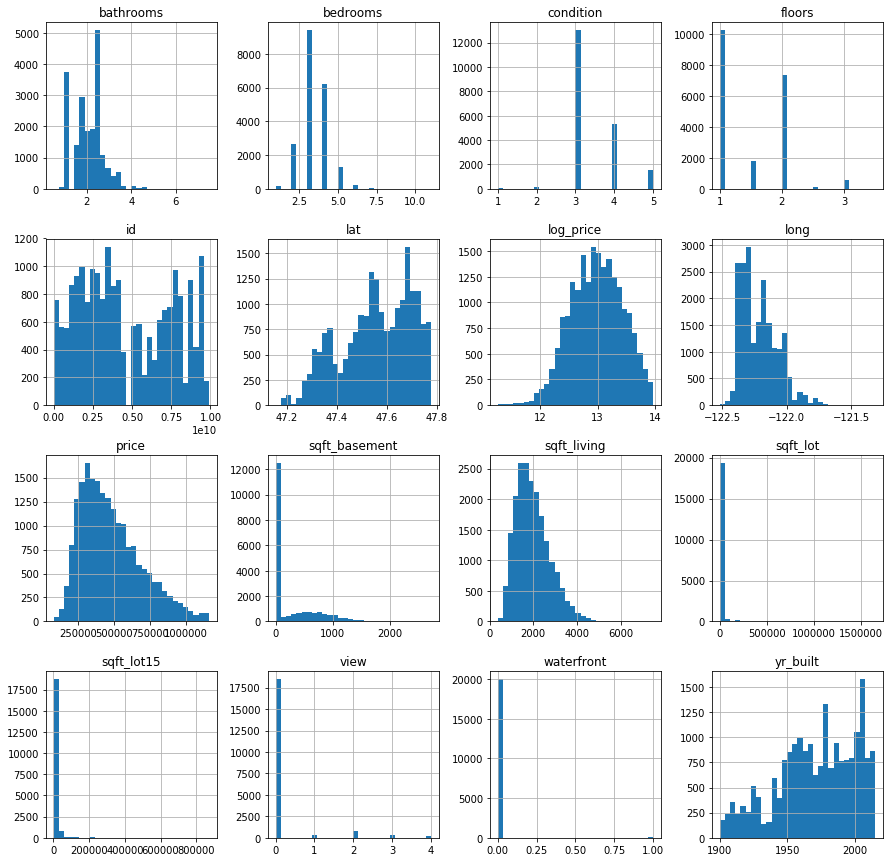

In [23]:
_ = house_data_95.hist(figsize=(15,15), bins=30)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price
id,1.000000,-0.016413,0.002267,0.005873,-0.011866,-0.132412,0.019150,-0.003588,0.012859,-0.023410,-0.004480,0.022179,-0.005062,0.021254,-0.138114,-0.004229
price,-0.016413,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.260777,0.397176,0.034613,0.323018,0.054849,0.307667,0.022512,0.083530,0.892694
bedrooms,0.002267,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,-0.001578,0.080379,0.025652,0.301987,0.156820,-0.009939,0.131398,0.030779,0.342500
bathrooms,0.005873,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.062055,0.187249,-0.128167,0.281813,0.508866,0.025243,0.224660,0.089414,0.550653
sqft_living,-0.011866,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.103331,0.283797,-0.061626,0.433369,0.319584,0.053213,0.241473,0.184920,0.695034
sqft_lot,-0.132412,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.021216,0.072668,-0.009207,0.015612,0.052469,-0.085076,0.230489,0.719499,0.099091
floors,0.019150,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.019853,0.027748,-0.264259,-0.245628,0.489898,0.049237,0.125360,-0.011632,0.309980
waterfront,-0.003588,0.260777,-0.001578,0.062055,0.103331,0.021216,0.019853,1.000000,0.380418,0.016293,0.082796,-0.024358,-0.011696,-0.036585,0.030188,0.168929
view,0.012859,0.397176,0.080379,0.187249,0.283797,0.072668,0.027748,0.380418,1.000000,0.045464,0.276521,-0.054415,0.006174,-0.076306,0.072797,0.345778
condition,-0.023410,0.034613,0.025652,-0.128167,-0.061626,-0.009207,-0.264259,0.016293,0.045464,1.000000,0.170361,-0.361838,-0.016021,-0.105805,-0.004386,0.037113


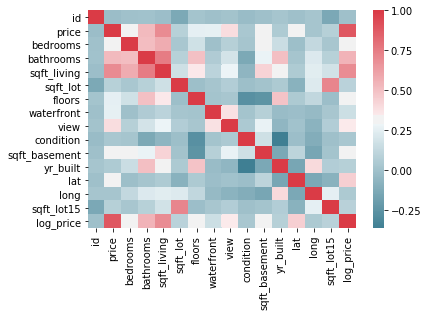

In [24]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)
house_data.corr()

In [25]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living'])
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

In [26]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

In [27]:
print(simple_linear_model(x_90, y_90, house_data_90))
print(simple_linear_model(x_95, y_95, house_data_95))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8599.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:39:13   Log-Likelihood:                -6691.3
No. Observations:               18972   AIC:                         1.339e+04
Df Residuals:                   18970   BIC:                         1.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3214      0.007   1737.105      0.0

In [28]:
def linear_y_hat(predictor, target):
    x = np.array(predictor)
    y = np.array(target)
    linreg = LinearRegression()
    linreg.fit(x.reshape(-1,1), y.reshape(-1,1))
    
    y_hat = linreg.predict(predictor.reshape(-1,1))
    return y_hat
    

In [29]:
y_hat_90 = linear_y_hat(x_90, y_90)
y_hat_95 = linear_y_hat(x_95, y_95)

y_hat_90, y_hat_95

(array([[12.70062032],
        [13.14731944],
        [12.56886015],
        ...,
        [12.64920172],
        [12.83559416],
        [12.64920172]]), array([[12.70288903],
        [13.18815444],
        [12.55975319],
        ...,
        [12.64703114],
        [12.84951599],
        [12.64703114]]))

In [30]:
def test_median_err(X, y):
    """Train a model on the variables provided and return that model's MAE."""
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [31]:
sqft_living_mae_90 = test_median_err(y_90.reshape(-1,1), y_hat_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(y_95.reshape(-1,1), y_hat_95.reshape(-1,1))

sqft_living_mae_90, sqft_living_mae_95

(52843.176385811414, 61377.23055454553)

In [32]:
#90th percentile seems to be a better fit that 95th for the customer that would be using the service. 

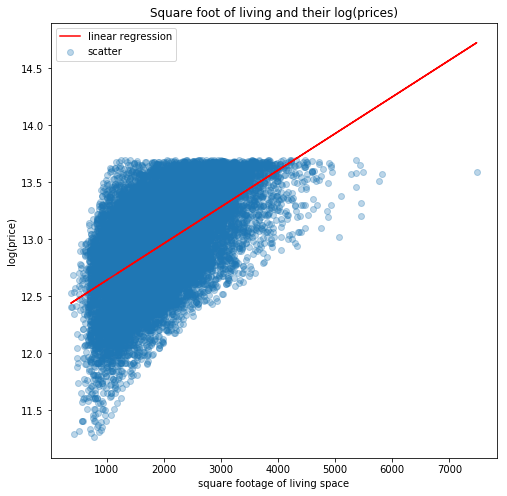

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(x_90,y_90, label='scatter', alpha = 0.3)
plt.plot(x_90, y_hat_90, color='red', label='linear regression')
plt.title('Square foot of living and their log(prices)')
plt.legend()
plt.xlabel('square footage of living space')
plt.ylabel('log(price)')
plt.show()

In [34]:
from datetime import datetime

house_data['date'] = pd.to_datetime(house_data['date'])

In [35]:
house_data['date'].sort_values().head()

16754   2014-05-02
19550   2014-05-02
14075   2014-05-02
21145   2014-05-02
16302   2014-05-02
Name: date, dtype: datetime64[ns]

What follows are our experiments with a preliminary multivariate model.

In [36]:
# preliminary multiple linear regression
outcome = 'log_price'
predictors = house_data.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data['log_price']), np.asarray(predictors_int)).fit()

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     4996.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:39:16   Log-Likelihood:                -8145.3
No. Observations:               21082   AIC:                         1.630e+04
Df Residuals:                   21076   BIC:                         1.635e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.3878      0.194    100.052      0.000      19.008      19.768
x1             0.0004   4.46e-06     80.202      0.000       0.000       0.000
x2            -0.0037   9.99e-05    -36.637      0.000      -0.004      -0.003
x3            -0.0605      0.003    -18.171      0.000      -0.067      -0.054
x4             0.1469      0.005     26.768      0.000       0.136       0.158
x5             0.0867      0.003     25.396      0.000       0.080       0.093
==============================================================================
Omnibus:                      249.057   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.000
Skew:                          -0.167   Prob(JB):                     1.80e-73
Kurtosis:                       3.520   Cond. No.                     2.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data['log_price'], test_size=0.3)

In [39]:
m_linreg = LinearRegression()

In [40]:
m_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [41]:
m_linreg.coef_

array([ 0.00036009, -0.00362827, -0.05912456,  0.14321312,  0.08713501])

In [42]:
m_linreg.intercept_

19.327190823555863

In [43]:
y_hat_train = m_linreg.predict(X_train)
y_hat_test = m_linreg.predict(X_test)

In [44]:
train_mae = median_absolute_error(y_train, y_hat_train)
test_mae = median_absolute_error(y_test,y_hat_test)

print('train: ' + str(train_mae) + 'test: ' + str(test_mae))

train: 0.2517455457820894test: 0.2543824298563031


In [45]:
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(m_linreg, predictors, house_data['log_price'], cv=5, scoring='neg_median_absolute_error')

In [46]:
cv_5_results = -1*cv_5_results

In [47]:
cv_5_results

array([0.25512967, 0.25268072, 0.2547601 , 0.25264014, 0.24576056])

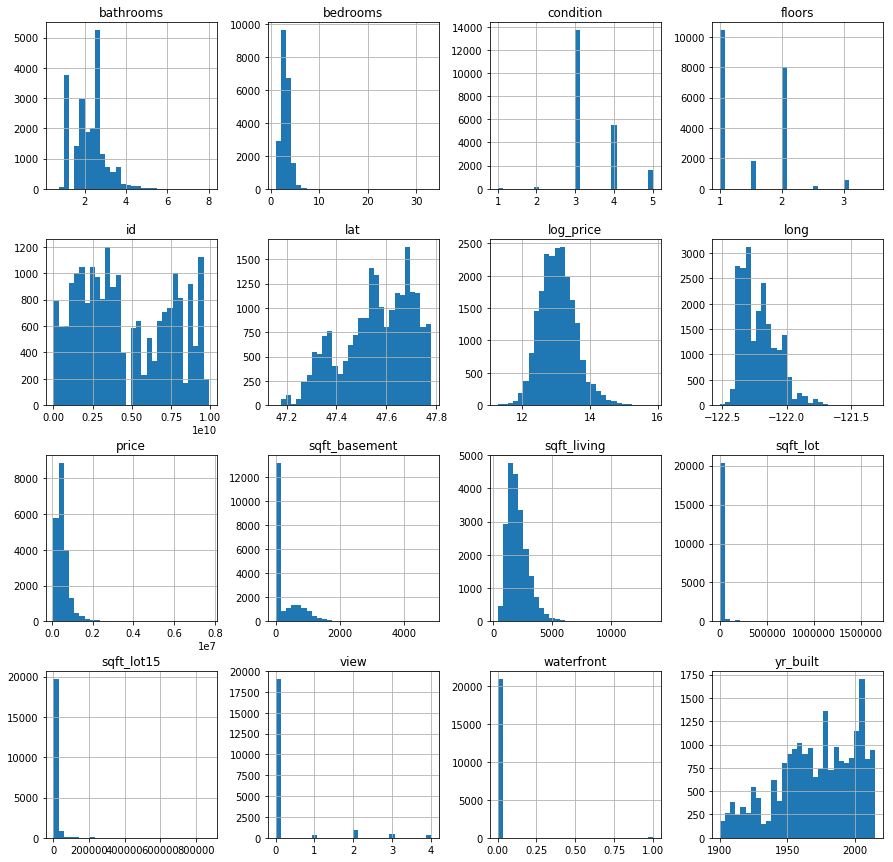

In [48]:
_ = house_data.hist(figsize=(15,15), bins=30)

In [49]:
! pip install --upgrade pip

Requirement already up-to-date: pip in /Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages (19.0.3)


In [50]:
! pip install haversine
from haversine import haversine

In [51]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

In [52]:
house_data['lat_long'] = list(zip(house_data['lat'], house_data['long']))
house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)"
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)"
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)"
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)"
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)"
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,1530.0,2001,47.6561,-122.005,101930,14.022525,"(47.6561, -122.005)"
8,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,730.0,1960,47.5123,-122.337,8113,12.343658,"(47.5123, -122.337)"
9,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,0.0,2003,47.3684,-122.031,7570,12.685408,"(47.3684, -122.031)"
10,1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,0.0,0.0,3,1700.0,1965,47.6007,-122.145,8925,13.403776,"(47.6007, -122.145)"
11,9212900260,2014-05-27,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,4,300.0,1942,47.6900,-122.292,6000,13.056224,"(47.69, -122.292)"


In [53]:
house_data['distance_from_downtown_sea'] = house_data['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

In [54]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434


In [55]:
# 1$ in 2014 is equivalently $1.07 in 2019 
# we may not use this
house_data['2019_price'] = house_data['price'].apply(lambda x: x*1.07)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15,log_price,lat_long,distance_from_downtown_sea,2019_price
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,0.0,1955,47.5112,-122.257,5650,12.309982,"(47.5112, -122.257)",7.770463,237433.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,400.0,1951,47.7210,-122.319,7639,13.195614,"(47.721000000000004, -122.319)",7.729926,575660.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,0.0,1933,47.7379,-122.233,8062,12.100712,"(47.7379, -122.23299999999999)",10.091232,192600.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,910.0,1965,47.5208,-122.393,5000,13.311329,"(47.5208, -122.39299999999999)",6.677113,646280.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,0.0,1987,47.6168,-122.045,7503,13.142166,"(47.6168, -122.045)",13.617434,545700.0


In [56]:
for column in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition']:
    print(simple_linear_model(house_data_90[column], house_data_90['price'], house_data_90))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1517.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):          2.45e-319
Time:                        12:39:23   Log-Likelihood:            -2.5552e+05
No. Observations:               18972   AIC:                         5.110e+05
Df Residuals:                   18970   BIC:                         5.111e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.683e+05   4847.896     55.339      0.0

In [57]:
X1 = house_data[['sqft_living', 'bedrooms', 'bathrooms']]
X2 = house_data[['lat', 'sqft_living']]
y = house_data['log_price']

In [58]:
def test_median_err(X, y):
    """Train a model on the variables provided and return that model's MAE."""
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [59]:
test_median_err(X1,y)

115775.98249413345

In [60]:
test_median_err(X2,y)

82508.70933791561

In [61]:
X3 = house_data[['distance_from_downtown_sea', 'sqft_living']]
test_median_err(X3, y)

89003.59281146612

In [62]:
predictors = house_data.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')
predictors.remove('2019_price')
predictors

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_lot15',
 'distance_from_downtown_sea']

In [63]:
predictor_mae = {}
for predictor in predictors:
    x = house_data[[predictor]]
    y = house_data['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

predictor_mae

{'id': 154706.5535317532,
 'bedrooms': 147990.94411292658,
 'bathrooms': 134813.0152650582,
 'sqft_living': 116394.25969937786,
 'sqft_lot': 153000.56925187996,
 'floors': 150609.21041515216,
 'waterfront': 152732.6642594934,
 'view': 146710.33245682926,
 'condition': 153664.8653308879,
 'sqft_basement': 145116.80280226603,
 'yr_built': 156157.67061210115,
 'lat': 128720.12101190774,
 'long': 154245.67479095887,
 'sqft_lot15': 153641.22628399733,
 'distance_from_downtown_sea': 138600.63358746312}

In [64]:
sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

[('sqft_living', 116394.25969937786),
 ('lat', 128720.12101190774),
 ('bathrooms', 134813.0152650582),
 ('distance_from_downtown_sea', 138600.63358746312),
 ('sqft_basement', 145116.80280226603),
 ('view', 146710.33245682926),
 ('bedrooms', 147990.94411292658),
 ('floors', 150609.21041515216),
 ('waterfront', 152732.6642594934),
 ('sqft_lot', 153000.56925187996),
 ('sqft_lot15', 153641.22628399733),
 ('condition', 153664.8653308879),
 ('long', 154245.67479095887),
 ('id', 154706.5535317532),
 ('yr_built', 156157.67061210115)]

In [65]:
X4 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

82899.63780335334

In [66]:
X5 = house_data[['sqft_living', 'lat', 'bathrooms']]
test_median_err(X5, y)

82360.29427794518

In [67]:
X6 = house_data[['lat', 'bathrooms']]
test_median_err(X6, y)

100643.79503763274

In [68]:
X7 = house_data[['sqft_living', 'distance_from_downtown_sea']]
test_median_err(X7, y)

88643.29450359514

In [69]:
X8 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

82869.3162064443

In [70]:
# for i in range(len(sorted_predictor_mae)):
#     for predictor in sorted_predictor_mae[:i+1]:
        

SyntaxError: unexpected EOF while parsing (<ipython-input-70-962000d41f3e>, line 3)

In [96]:
kf = KFold(n_splits=2)
kf.get_n_splits(X3)

2

In [102]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linreg = LinearRegression()
    test_err = []
    linreg.fit(X_train, y_train)
    y_hat_test = linreg.predict(X_test)
    invert_y_hat_test = np.exp(y_hat_test)
    invert_y_test = np.exp(y_test)
    test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    print(np.mean(test_err))

TRAIN: [2 3] TEST: [0 1]
0.5830801062452297
TRAIN: [0 1] TEST: [2 3]
2.6514474146500797


In [ ]:
# I don't know whats going on here